In [ ]:
import json
import os
import time
from glob import glob


import numpy as np
import pandas as pd


import librosa
import librosa as lb  # Gunakan salah satu jika alias diperlukan
import tensorflow_io as tfio


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

from joblib import Parallel, delayed
from skimage.transform import resize
from tqdm import tqdm


In [13]:
df = pd.read_csv("data_asv_spoof.csv", sep = ";")
df

,speaker_id,filename,class_name,filepath,target
0,LA_0079,LA_T_1138215,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0
1,LA_0079,LA_T_1271820,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0
2,LA_0079,LA_T_1272637,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0
3,LA_0079,LA_T_1276960,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0
4,LA_0079,LA_T_1341447,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0
...,...,...,...,...,...
121456,LA_0004,LA_E_1665632,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0
121457,LA_0038,LA_E_5085671,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1
121458,LA_0012,LA_E_4926022,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1
121459,LA_0052,LA_E_2894498,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0


In [19]:
df.groupby(by="target").count()

,speaker_id,filename,class_name,filepath
target,,,,
0,12483,12483,12483,12483
1,108978,108978,108978,108978


In [14]:
def balance_dataset(df, target_column='target', ratio=(5, 4), random_state=42):
    # Split the data into two groups based on the target
    class_0 = df[df[target_column] == 0]
    class_1 = df[df[target_column] == 1]

    # Menentukan mayoritas dan minoritas berdasarkan jumlah sampel awal
    if len(class_0) > len(class_1):
        class_majority = class_0
        class_minority = class_1
    else:
        class_majority = class_1
        class_minority = class_0

    # Menentukan jumlah sampel berdasarkan rasio
    minority_count = len(class_minority)
    majority_count = int((ratio[0] / ratio[1]) * minority_count)

    # Jika majority_count lebih besar dari data yang tersedia, gunakan jumlah maksimum yang mungkin
    majority_count = min(majority_count, len(class_majority))

    # Sampling data untuk memenuhi rasio yang diinginkan
    class_majority_sampled = class_majority.sample(n=majority_count, random_state=random_state)

    # Menggabungkan kembali dataset yang telah diatur ulang
    balanced_df = pd.concat([class_minority, class_majority_sampled])

    # Shuffle dataset agar distribusi kelas acak
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Menampilkan distribusi kelas setelah penyesuaian
    print("Class distribution after balancing:")
    print(balanced_df[target_column].value_counts())

    return balanced_df


In [15]:
data_full = balance_dataset(df, target_column='target', random_state=42)

Class distribution after balancing:
target
1    15603
0    12483
Name: count, dtype: int64


In [16]:
data_full.sample(10)

,speaker_id,filename,class_name,filepath,target
21821,LA_0050,LA_E_3536152,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0
20445,LA_0073,LA_D_4838987,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1
18125,LA_0024,LA_E_1556129,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1
10077,LA_0083,LA_T_3819369,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1
19956,LA_0017,LA_E_5301686,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0
22476,LA_0014,LA_E_5404456,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1
12915,LA_0088,LA_T_3339055,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1
233,LA_0015,LA_E_7571989,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1
789,LA_0047,LA_E_7795333,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0
5580,LA_0027,LA_E_7443235,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1


In [17]:
data_full.to_csv("data_full_balanced.csv", sep = ";", index=False)

## Introduction

In [ ]:
#REAL
data_real = df.iloc[5,4]
y_real,sr = lb.load(data_real)
mel_spectrogram_real = create_mel_spectrogram_cara3(y_real)

# Plot Mel spectrogram
Audio(y_real, rate = sr)

In [22]:
data = pd.read_csv("data_full_balanced.csv", sep = ";")
data.head(5)

,speaker_id,filename,class_name,filepath,target
0,LA_0032,LA_E_6834922,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1
1,LA_0015,LA_E_2797984,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0
2,LA_0043,LA_E_4957204,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1
3,LA_0017,LA_E_7932808,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1
4,LA_0071,LA_D_6178956,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0


In [40]:
ex_fake = data.iloc[0,3]
y_fake,sr = lb.load(ex_fake, sr = None)
print(sr)
Audio(y_fake, rate = sr)

16000


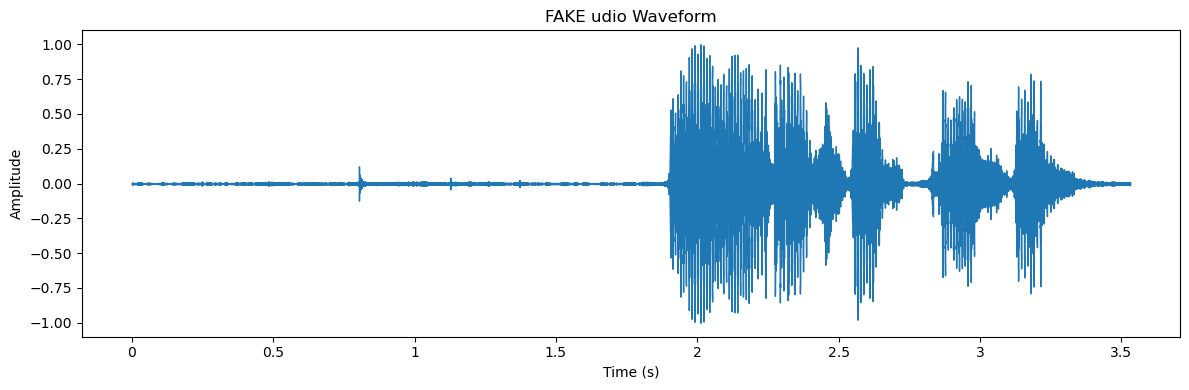

In [45]:
# Plot the waveform
plt.figure(figsize=(12, 4))
lb.display.waveshow(y_fake, sr=sr)
plt.title('FAKE udio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [42]:
ex_real = data.iloc[1,3]
y_real,sr = lb.load(ex_real, sr = None)
print(sr)
Audio(y_real, rate = sr)

16000


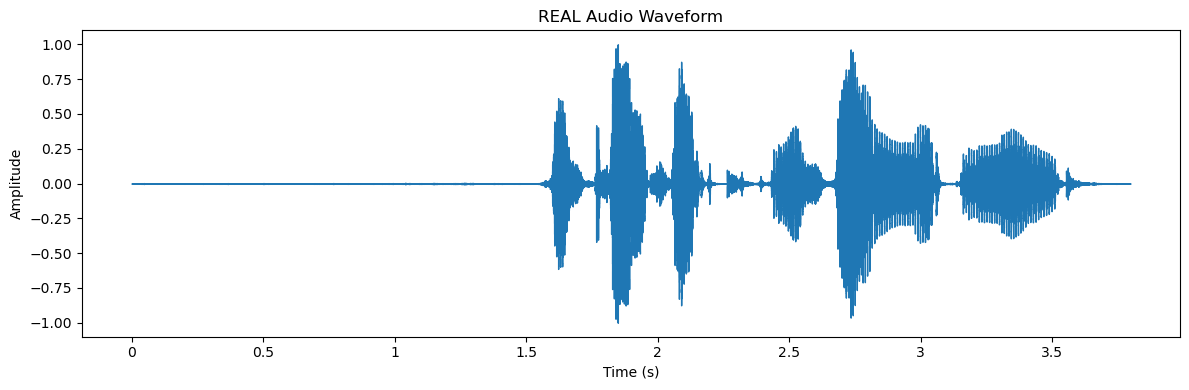

In [46]:
# Plot the waveform
plt.figure(figsize=(12, 4))
lb.display.waveshow(y_real, sr=sr)
plt.title('REAL Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

## Feature Extraction

In [48]:
df = pd.read_csv("data_full_balanced.csv", sep = ";")
df

,speaker_id,filename,class_name,filepath,target
0,LA_0032,LA_E_6834922,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1
1,LA_0015,LA_E_2797984,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0
2,LA_0043,LA_E_4957204,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1
3,LA_0017,LA_E_7932808,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1
4,LA_0071,LA_D_6178956,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0
...,...,...,...,...,...
28081,LA_0072,LA_D_1860065,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1
28082,LA_0059,LA_E_5288472,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0
28083,LA_0085,LA_T_7477418,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0
28084,LA_0011,LA_E_7212935,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1


In [49]:
df_train, df_test = train_test_split(data, test_size=0.2, stratify=data['target'], random_state=42)

In [50]:
df_train.groupby(by="class_name").count()

,speaker_id,filename,filepath,target
class_name,,,,
bonafide,9986,9986,9986,9986
spoof,12482,12482,12482,12482


In [51]:
df_test.groupby(by="class_name").count()

,speaker_id,filename,filepath,target
class_name,,,,
bonafide,2497,2497,2497,2497
spoof,3121,3121,3121,3121


### Numeric Data

In [52]:

def extract_features_optimized(df, scaler=None, fit_scaler=False, n_jobs=-1):
    start_time = time.perf_counter()
    def _process_file(filepath, target):
        try:
            y, sr = librosa.load(filepath, sr=16000, mono=True)
            S = np.abs(librosa.stft(y))

            chroma = librosa.feature.chroma_stft(S=S, sr=sr).mean(axis=1)
            rms = librosa.feature.rms(S=S).mean()
            spectral_centroid = librosa.feature.spectral_centroid(S=S, sr=sr).mean()
            spectral_bandwidth = librosa.feature.spectral_bandwidth(S=S, sr=sr).mean()
            spectral_rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr).mean()
            zcr = librosa.feature.zero_crossing_rate(y).mean()
            mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), sr=sr, n_mfcc=20).mean(axis=1)

            return [*chroma, rms, spectral_centroid, spectral_bandwidth,
                    spectral_rolloff, zcr, *mfccs, int(target)]
        except Exception as e:
            print(f"Error processing {filepath}: {e}")
            return None

    features = Parallel(n_jobs=n_jobs)(
        delayed(_process_file)(row["filepath"], row["target"])
        for _, row in tqdm(df.iterrows(), total=len(df))
    )

    features = [f for f in features if f is not None]  # filter gagal

    columns = (
        [f'chroma_{i+1}' for i in range(12)] +
        ['rms_mean', 'spectral_centroid_mean', 'spectral_bandwidth_mean',
         'spectral_rolloff_mean', 'zcr_mean'] +
        [f'mfcc_{i+1}' for i in range(20)] + ['label']
    )

    features_df = pd.DataFrame(features, columns=columns)

    feature_columns = columns[:-1]
    if fit_scaler:
        scaler = MinMaxScaler()
        features_df[feature_columns] = scaler.fit_transform(features_df[feature_columns])
    elif scaler is not None:
        features_df[feature_columns] = scaler.transform(features_df[feature_columns])
    else:
        pass  # no scaling applied

    elapsed_time = time.perf_counter() - start_time

    return features_df, scaler, elapsed_time


In [ ]:
train_features, scaler, train_time = extract_features_optimized(df_train, fit_scaler=True)
test_features, _, test_time = extract_features_optimized(df_test, scaler=scaler, fit_scaler=False)

 33%|███▎      | 7488/22468 [02:10<04:04, 61.36it/s]

In [ ]:
train_features.to_csv("numeric_train_data.csv", index=False)
test_features.to_csv("numeric_test_data.csv", index=False)

### Image Data - CNN

In [ ]:
def process_full_audio_data_parallel(train_df, sr=16000, n_mels=128, fixed_frames=128, n_jobs=-1):
    start_time = time.perf_counter()

    def create_mel_spectrogram_full(y, label):
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_resized = resize(mel_spectrogram_db, (n_mels, fixed_frames), mode='reflect', anti_aliasing=True)
        mel_standard = (mel_resized + 80) / 80
        mel_segments = np.expand_dims(mel_standard, axis=-1)
        return mel_segments

    def process_row(row):
        try:
            y, _ = librosa.load(row["filepath"], sr=sr, mono=True)
            label = 0 if row["target"] == 0 else 1
            mel_spectrogram = create_mel_spectrogram_full(y, label)
            return mel_spectrogram, label
        except Exception as e:
            print(f"Error processing file {row['filepath']}: {e}")
            return None

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(row) for _, row in tqdm(train_df.iterrows(), total=len(train_df))
    )

    results = [res for res in results if res is not None]

    if not results:
        return np.array([]), np.array([]), 0

    train_samples_full, train_labels = zip(*results)

    elapsed_time = time.perf_counter() - start_time
    return np.array(train_samples_full), np.array(train_labels), elapsed_time


In [ ]:
X_train_full, y_train_full, time_train_full = process_full_audio_data_parallel(df_train)


In [ ]:
X_test_full, y_test_full, time_test_full = process_full_audio_data_parallel(df_test)

In [ ]:
np.savez("cnn_train_data.npz", data=X_train_full, label = y_train_full)
np.savez("cnn_test_data.npz", data=X_test_full, label = y_test_full)

### Image Data-CNN_LSTM

In [ ]:


def process_step_audio_data_parallel(train_df, sr=16000, n_mels=128, fixed_frames=128, timesteps=32, n_jobs=-1):
    start_time = time.perf_counter()

    def create_mel_spectrogram_timestep(y):
        mel_spectrogram = lb.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spectrogram_db = lb.power_to_db(mel_spectrogram, ref=np.max)
        mel_spectrogram_db = (mel_spectrogram_db + 80) / 80
        resized_mel_spectrogram = resize(mel_spectrogram_db, (n_mels, fixed_frames), mode='reflect', anti_aliasing=True)
        
        segment_length = fixed_frames // timesteps
        mel_segments = [resized_mel_spectrogram[:, i * segment_length:(i + 1) * segment_length] for i in range(timesteps)]
        mel_segments = np.array(mel_segments)
        mel_segments = np.expand_dims(mel_segments, axis=-1)  # Add channel dimension

        return mel_segments

    def process_row(row):
        try:
            y, _ = lb.load(row["filepath"], sr=sr, mono=True)
            label = 0 if row["target"] == 0 else 1
            mel = create_mel_spectrogram_timestep(y)
            return mel, label
        except Exception as e:
            print(f"Error processing file {row['filepath']}: {e}")
            return None

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(row) for _, row in tqdm(train_df.iterrows(), total=len(train_df))
    )

    results = [r for r in results if r is not None]

    if not results:
        return np.array([]), np.array([]), 0

    train_samples_step, train_labels = zip(*results)

    elapsed_time = time.perf_counter() - start_time
    return np.array(train_samples_step), np.array(train_labels), elapsed_time


In [ ]:
X_train_step, y_train_step, time_train_step = process_step_audio_data_parallel(df_train)
X_test_step, y_test_step, time_test_step = process_step_audio_data_parallel(df_test)

In [ ]:
np.savez("cnn_lstm_train_data.npz", data=X_train_step, label = y_train_step)
np.savez("cnn_lstm_test_data.npz", data=X_test_step, label = y_test_step)